# **Step3. 속성 기반 감정 분류**

**미션 : 리뷰 안에 담긴 11가지 속성 감성 분석하기(Aspect-Based Sentiment Analysis)**
1) 목표 : 속성 기반 감성 분석을 통해, 리뷰 내용을 속성에 따라 긍, 부정
으로 분류하는 모델 생성
2) 절차① : “[ASPECT] 속성 [SEP] 문장”
    * 데이터 전처리 : 데이터셋 구성, 토크나이즈
    * 스페셜 토큰 추가 + 모델의 임베딩 층 resizing
    * 파인튜닝 및 모델 평가
3) 절차② : “Aspect : 문장”
    * 데이터 전처리 : 데이터셋 구성, 토크나이즈
    * 파인튜닝 및 모델 평가
4) 성능 비교 : “Aspect : 문장”
    * 모델 별 : klue/bert-base, klue/RoBERTa-base
    * 전처리 별 : Case①, Case②
    * Macro Recall, Macro Precision, Macro F1-Score 비교

## 1.환경준비

### (1) 라이브러리 설치 및 로딩

In [1]:
# 한글폰트 설치
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import torch

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

### (2) 데이터 로딩
* data.csv 파일 로딩

In [3]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (6).csv


In [4]:
df = pd.read_csv('data.csv')
df.head()

,text,aspect,label
0,유통기한도 넉넉하고 구성도 많아서 선물 하기 좋네요. 만족합니다.,포장,1
1,유통기한도 넉넉하고 구성도 많아서 선물 하기 좋네요. 만족합니다.,품질,1
2,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,보습,1
3,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,포장,0
4,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,기타,1


* 전제 데이터 중 10,000건만 샘플링
    * 학습 속도 고려

In [5]:
# 데이터 샘플링
df = df.sample(10000)

### (3) GPU 설정
* GPU 사용을 위한 설정

In [6]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.방식① : [ASPECT] 속성 [SEP] 문장

* 두가지 모델에 대해서 튜닝을 시도해봅시다.
    * model_name1 = "klue/bert-base"
    * model_name2 = "klue/roberta-base"

### (1) 데이터 준비
* 데이터셋 분할 및 텐서 데이터셋 변환
* 토크나이징 함수 안에서,
    * "[ASPECT] 속성 [SEP] 문장" 형태로 수정
    * 토크나이징

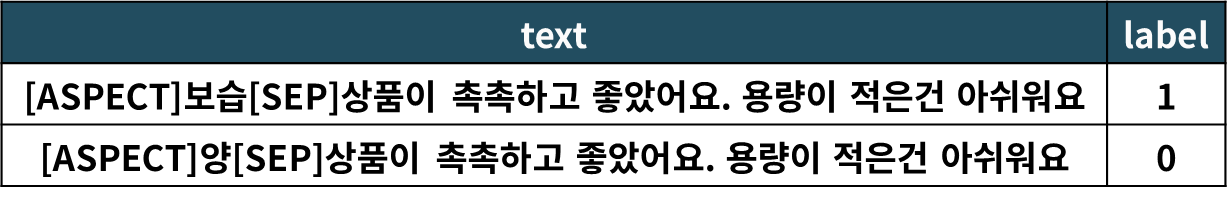

#### 1) 데이터셋 분할 및 텐서 데이터셋 변환

In [7]:
aspects = ['보습', '기능', '밀착', '가격', '향', '편의성', '기타', '외형', '포장', '품질', '피부']

In [8]:
# train, val 데이터 분할
train, val = train_test_split(df, test_size=0.3, random_state=100)

In [9]:
# df로 부터 텐서 데이터셋 만들기
train_ts = Dataset.from_pandas(train)
val_ts = Dataset.from_pandas(val)

In [10]:
train_ts[:3]

{'text': ['가격 착하고 향도 좋고 세팅력도 좋아서 자주 구매하게 되네요.',
  '정품이 맞는지 궁금합니다. 케이스가 견고하지 않는 것 같아요. 많이 매트합니다. 오전에 바르고 오후되니 화장이 다 뜨네요.',
  '날씨가 너무 추워져서 입술이 정말 건조한 것 같아요!! 건조할 때는 이 립밤을 바르시는 것을 추천 드릴게요!! 리뷰 바로 시작할게요~ㅎㅎ 보습력이 너무 좋아서 한 겨울에 이것만 발라도 입술이 절대 갈라지거나 건조하지 않는 꿀 아이템이라고 할 수 있어요!! 저는 개인적으로 이 립밤이 품질이 가장 좋은 것 같습니다! 사이즈도 들고 다니기 편하고 사용하기도 간편하게 제작이 되어 좋은 것 같아요! 향도 없어서 마음에 들고 무엇보다 뭉치지 않고 잘 발려서 정말 좋은 것 같습니다!! 겨울에 사용하기 좋은 립밤 찾으시면 저는 이 제품을 강력 추천 드리고 싶네요 ㅎㅎ'],
 'aspect': ['기능', '보습', '편의성'],
 'label': [1, 0, 1],
 '__index_level_0__': [12388, 51405, 37510]}

#### 2) 토크나이징
* "[ASPECT] 속성 [SEP] 문장" 형태로 수정
* 다중 레이블 분류 문제에서 label은 float 타입이어야 함

* 토크나이저 준비 : 두 모델에 대한 토크나이저 로딩

In [11]:
# 토크나이저 다운로드
model_name1 = "klue/bert-base"
model_name2 = "klue/roberta-base"
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
tokenizer2= AutoTokenizer.from_pretrained(model_name2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


* 사용자 정의 스페셜 토큰 등록하기

In [12]:
# 사용자 정의 스페셜 토큰 목록(aspect(속성) 토큰을 직접 모델에 추가해주는 과정)
special_tokens_dict = {"additional_special_tokens": ["[ASPECT]"]}

# 토크나이저에 추가
num_added_toks1 = tokenizer1.add_special_tokens(special_tokens_dict)
num_added_toks2 = tokenizer2.add_special_tokens(special_tokens_dict)
print(f"Added {num_added_toks1} special tokens: {special_tokens_dict['additional_special_tokens']}")
print(f"Added {num_added_toks2} special tokens: {special_tokens_dict['additional_special_tokens']}")


Added 1 special tokens: ['[ASPECT]']
Added 1 special tokens: ['[ASPECT]']


* 토크나이징을 포함한 함수 생성 및 적용

In [13]:
# ===============================
# 0) 라벨 이름(반드시 실제 순서로 기입)
# ===============================
label_names = ['보습', '기능', '밀착', '가격', '향', '편의성', '기타', '외형', '포장', '품질', '피부']

def preprocess_aspect_pair_tok1(batch):
    # 첫 번째 시퀀스: "[ASPECT] {속성}", 두 번째 시퀀스: 문장
    left = [f"[ASPECT] {a}" for a in batch["aspect"]]
    tok = tokenizer1(
        left,
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tok["labels"] = batch["label"]  # 0/1 (int)
    return tok

def preprocess_aspect_pair_tok2(batch):
    left = [f"[ASPECT] {a}" for a in batch["aspect"]]
    tok = tokenizer2(
        left,
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tok["labels"] = batch["label"]
    return tok

train_tok1 = train_ts.map(preprocess_aspect_pair_tok1, batched=True, remove_columns=[c for c in train_ts.column_names if c not in ["aspect","text","label"]])
val_tok1   = val_ts.map(preprocess_aspect_pair_tok1,   batched=True, remove_columns=[c for c in val_ts.column_names   if c not in ["aspect","text","label"]])

train_tok2 = train_ts.map(preprocess_aspect_pair_tok2, batched=True, remove_columns=[c for c in train_ts.column_names if c not in ["aspect","text","label"]])
val_tok2   = val_ts.map(preprocess_aspect_pair_tok2,   batched=True, remove_columns=[c for c in val_ts.column_names   if c not in ["aspect","text","label"]])

# 텐서 포맷
train_tok1.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_tok1.set_format(type="torch",   columns=["input_ids","attention_mask","labels"])
train_tok2.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_tok2.set_format(type="torch",   columns=["input_ids","attention_mask","labels"])


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

### (2) Fine-Tuning

#### 1) 사전학습 모델 준비
* 모델 로드한 후
* 반드시 `모델.resize_token_embeddings(len(tokenizer))`

In [14]:
# 모델1
num_labels = 2
model1 = AutoModelForSequenceClassification.from_pretrained(model_name1, num_labels=num_labels)


model1 = AutoModelForSequenceClassification.from_pretrained(model_name1, num_labels=2)
model1.resize_token_embeddings(len(tokenizer1))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32001, 768, padding_idx=0)

In [15]:
# 모델2
num_labels = 2
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2, num_labels=num_labels)

model2 = AutoModelForSequenceClassification.from_pretrained(model_name2, num_labels=2)
model2.resize_token_embeddings(len(tokenizer2))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32001, 768, padding_idx=1)

#### 2) 학습 설정

* TrainingArguments 설정
    * 두 모델에 공통으로 하나만 설정해도 됨

In [16]:
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,               # 작은 학습률
    per_device_train_batch_size = 32,   # 학습 배치 사이즈
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,               # 에폭 수
    weight_decay = 0.02,                # weight decay
    load_best_model_at_end = True,      # earlystopping 사용하기 위해 필요
    logging_dir ='./logs',
    logging_steps = 10,
    report_to="tensorboard"
)

* Trainer 설정
    * 두 모델 각각 설정

In [17]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred        # logits: (B, 2), labels: (B,)
    preds = np.argmax(logits, axis=-1)
    labels = labels.reshape(-1)       # 혹시 (B,1)로 들어오면 평탄화
    return {
        "accuracy": accuracy_score(labels, preds),
        "weighted_f1": f1_score(labels, preds, average="weighted"),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }


In [20]:
# Trainer1 설정
trainer1 = Trainer(
    model=model1,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_tok1,
    eval_dataset = val_tok1,
    tokenizer = tokenizer1,
    compute_metrics=compute_metrics,     # 추가 측정 지표
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)


# Trainer2 설정
trainer2 = Trainer(
    model=model2,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_tok2,
    eval_dataset = val_tok2,
    tokenizer = tokenizer2,
    compute_metrics=compute_metrics,     # 추가 측정 지표
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)


/tmp/ipython-input-801383113.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(
/tmp/ipython-input-801383113.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


#### 3) 학습

In [21]:
# 모델 학습
trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted F1,Macro F1
1,0.252900,0.211693,0.916333,0.914487,0.888295
2,0.135400,0.201413,0.925333,0.925682,0.905293
3,0.117300,0.212380,0.938333,0.938271,0.920881
4,0.120900,0.263481,0.938667,0.938617,0.921340
5,0.081200,0.292770,0.937333,0.937283,0.919630


TrainOutput(global_step=1095, training_loss=0.13306123343504728, metrics={'train_runtime': 869.5975, 'train_samples_per_second': 40.249, 'train_steps_per_second': 1.259, 'total_flos': 2302221734400000.0, 'train_loss': 0.13306123343504728, 'epoch': 5.0})

In [22]:
# 모델 학습
trainer2.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted F1,Macro F1
1,0.275400,0.250155,0.888333,0.881000,0.839651
2,0.150100,0.226746,0.922000,0.922765,0.902121
3,0.067300,0.240950,0.931667,0.931653,0.912468
4,0.090600,0.259605,0.935000,0.934987,0.916738
5,0.052900,0.304826,0.937000,0.936987,0.919299


TrainOutput(global_step=1095, training_loss=0.1543420876133932, metrics={'train_runtime': 870.0769, 'train_samples_per_second': 40.226, 'train_steps_per_second': 1.259, 'total_flos': 2302221734400000.0, 'train_loss': 0.1543420876133932, 'epoch': 5.0})

#### 4) 모델 검증평가

* 예측

In [25]:
# =========================
# 1) 예측 (Predict)
# =========================
raw_pred1 = trainer1.predict(val_tok1)
raw_pred2 = trainer2.predict(val_tok2)

# logits → 예측 라벨
logits1 = raw_pred1.predictions
logits2 = raw_pred2.predictions

y_true1 = raw_pred1.label_ids
y_true2 = raw_pred2.label_ids

y_pred1 = logits1.argmax(axis=1)
y_pred2 = logits2.argmax(axis=1)

In [ ]:
# pred1 = raw_pred1.prediction.argmax(axis=1) # 1, 0 으로 변환
# true1 = raw_pred1.label_ids # 정답 1, 0

# pred2 = raw_pred2.prediction.argmax(axis=1) # 1, 0 으로 변환
# true2 = raw_pred2.label_ids # 정답 1, 0

In [60]:
# =========================
# 4) 속성별 성능 비교
# =========================
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import seaborn as sns

# val의 aspect 추출
val_aspects = list(val["aspect"].values)
aspect_list = aspects  # ['보습', '기능', '밀착', ..., '피부']

def per_aspect_scores(y_true, y_pred, aspect_seq, aspect_names):
    rows = []
    for a in aspect_names:
        idx = [i for i, x in enumerate(aspect_seq) if x == a]
        if len(idx) == 0:
            rows.append((a, np.nan, np.nan, np.nan, 0))
            continue
        yt = np.array(y_true)[idx]
        yp = np.array(y_pred)[idx]
        p, r, f1, sup = precision_recall_fscore_support(
            yt, yp, average="binary", zero_division=0
        )
        rows.append((a, p, r, f1, sup))
    return pd.DataFrame(rows, columns=["label","precision","recall","f1","support"])

df_aspect_m1 = per_aspect_scores(y_true1, y_pred1, val_aspects, aspect_list)
df_aspect_m2 = per_aspect_scores(y_true2, y_pred2, val_aspects, aspect_list)

print("\n[Model1] per-aspect metrics")
display(df_aspect_m1)

print("\n[Model2] per-aspect metrics")
display(df_aspect_m2)


[Model1] per-aspect metrics


,label,precision,recall,f1,support
0,보습,0.948980,0.948980,0.948980,None
1,기능,0.936667,0.946128,0.941374,None
2,밀착,0.933036,0.941441,0.937220,None
3,가격,0.994924,0.984925,0.989899,None
4,향,0.978355,0.961702,0.969957,None
5,편의성,0.944444,0.995122,0.969121,None
6,기타,0.955128,0.876471,0.914110,None
7,외형,0.966480,0.940217,0.953168,None
8,포장,0.944954,0.858333,0.899563,None
9,품질,0.958333,0.926174,0.941980,None



[Model2] per-aspect metrics


,label,precision,recall,f1,support
0,보습,0.959732,0.972789,0.966216,None
1,기능,0.943144,0.949495,0.946309,None
2,밀착,0.927885,0.869369,0.897674,None
3,가격,0.994845,0.969849,0.982188,None
4,향,0.982301,0.944681,0.963124,None
5,편의성,0.971014,0.980488,0.975728,None
6,기타,0.936709,0.870588,0.902439,None
7,외형,0.955307,0.929348,0.942149,None
8,포장,0.972222,0.875000,0.921053,None
9,품질,0.958621,0.932886,0.945578,None


* 평가 : model1

=== Model1 (klue/bert-base) ===
              precision    recall  f1-score   support

           0      0.849     0.875     0.862       798
           1      0.954     0.944     0.949      2202

    accuracy                          0.925      3000
   macro avg      0.902     0.909     0.905      3000
weighted avg      0.926     0.925     0.926      3000



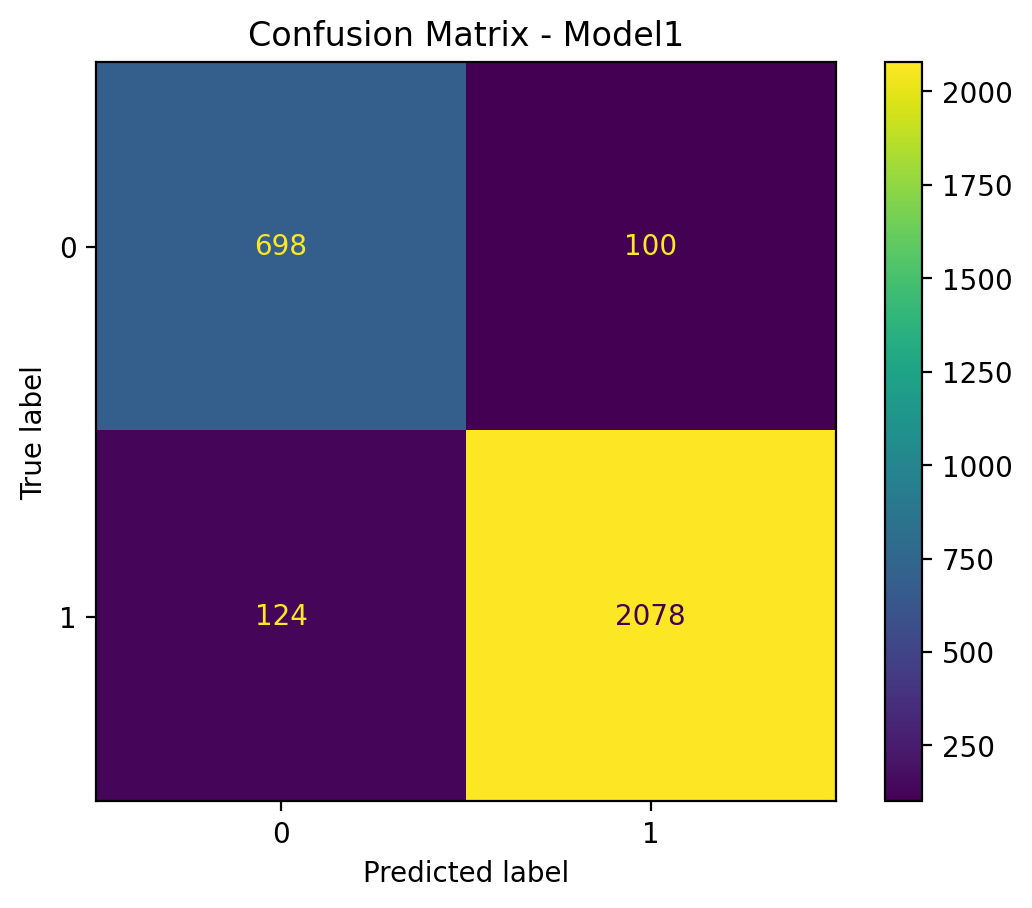

In [58]:
# =========================
# 2) Model1 평가
# =========================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("=== Model1 (klue/bert-base) ===")
print(classification_report(y_true1, y_pred1, target_names=["0","1"], digits=3))

cm1 = confusion_matrix(y_true1, y_pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["0","1"])
disp1.plot()
plt.title("Confusion Matrix - Model1")
plt.show()


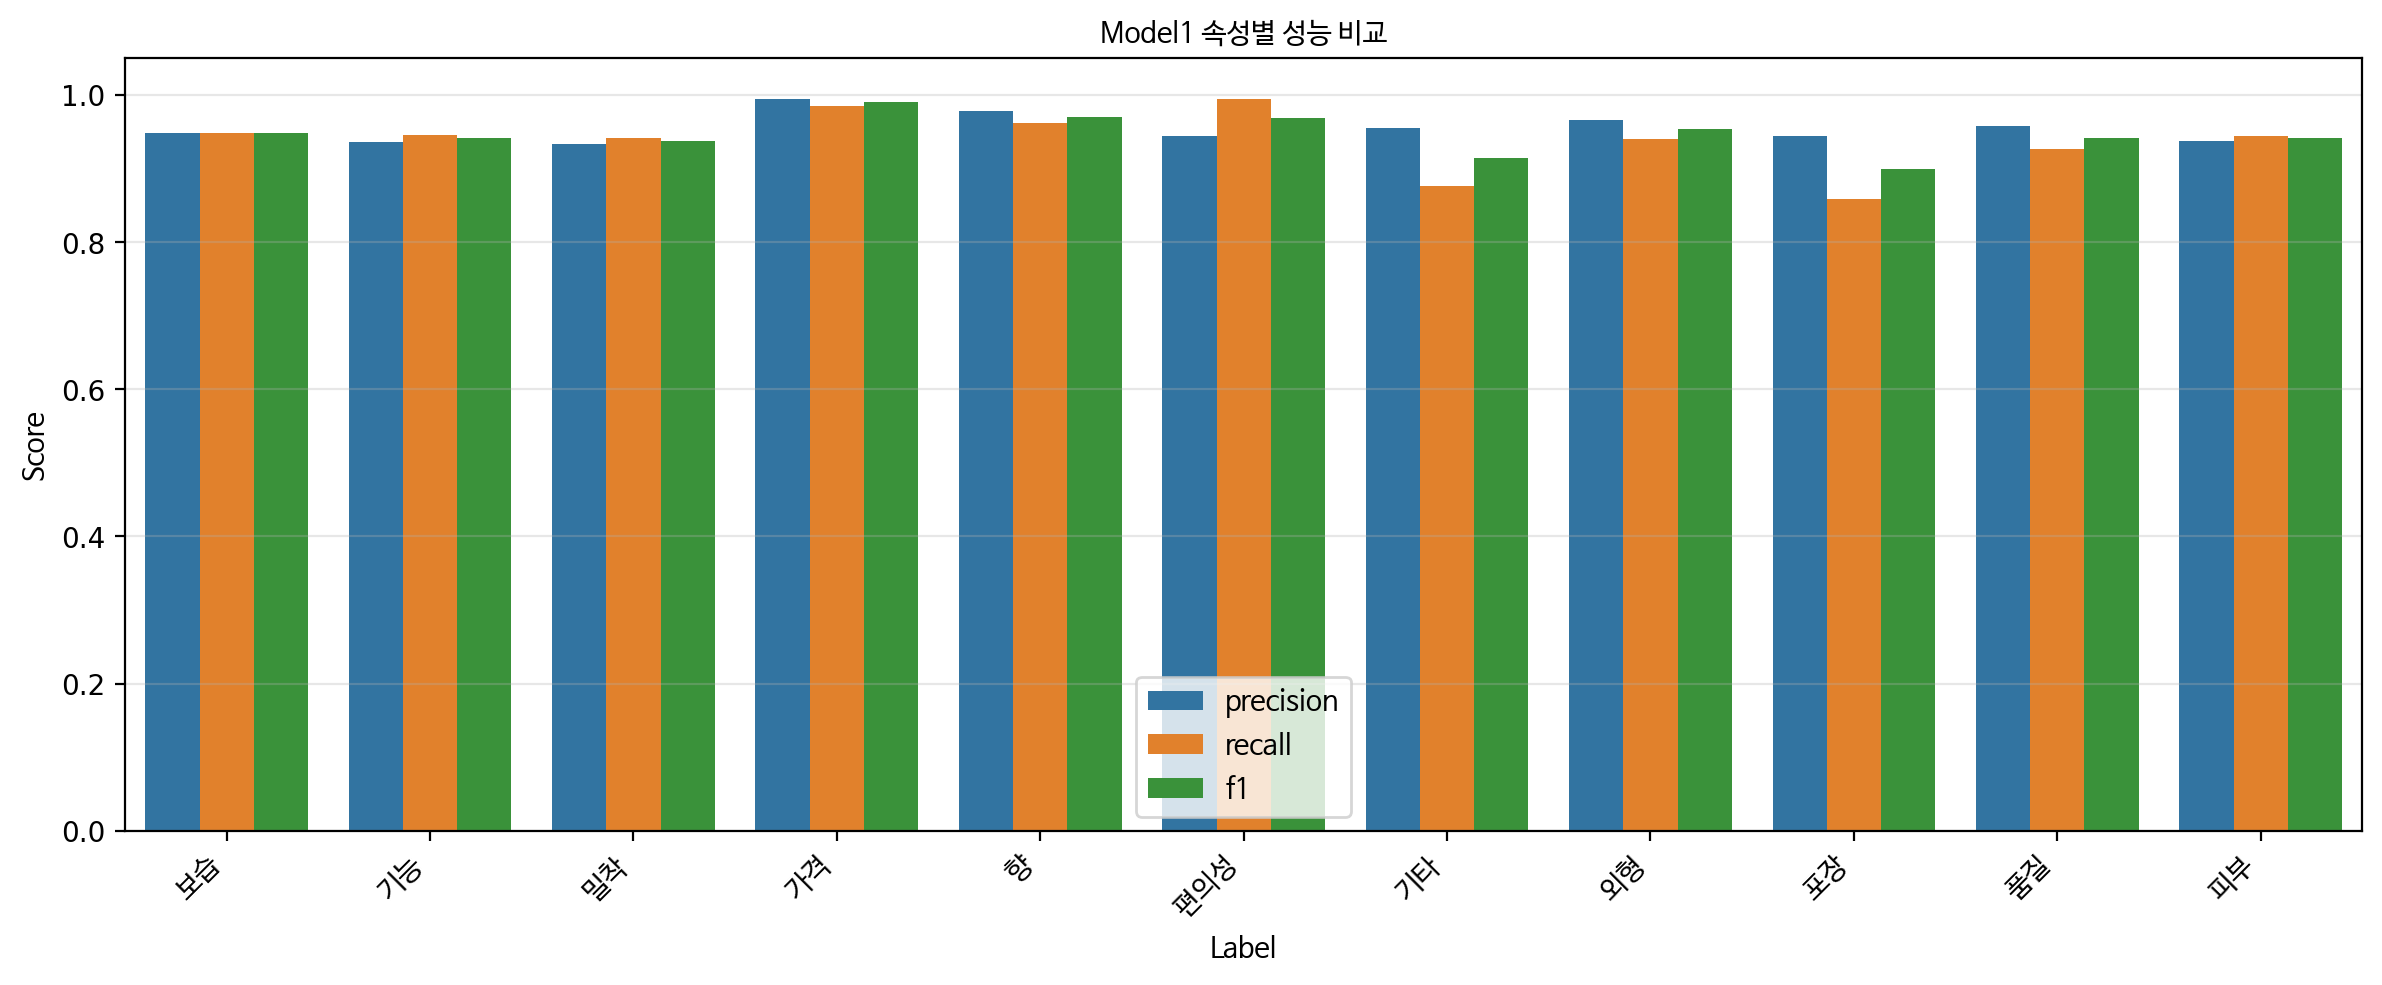

In [29]:
# barplot (Model1 예시)
df_melted = df_aspect_m1.melt(id_vars='label', value_vars=['precision', 'recall', 'f1'],
                              var_name='metric', value_name='score')

plt.figure(figsize=(12,5))
sns.barplot(data=df_melted, x='label', y='score', hue='metric')
plt.xticks(rotation=45, ha='right', fontproperties=fontprop)
plt.title("Model1 속성별 성능 비교", fontproperties=fontprop)
plt.ylabel("Score", fontproperties=fontprop)
plt.xlabel("Label", fontproperties=fontprop)
plt.ylim(0, 1.05)
plt.legend(prop=fontprop)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


* 평가 : model2

=== Model2 (klue/roberta-base) ===
              precision    recall  f1-score   support

           0      0.832     0.886     0.858       798
           1      0.958     0.935     0.946      2202

    accuracy                          0.922      3000
   macro avg      0.895     0.911     0.902      3000
weighted avg      0.924     0.922     0.923      3000



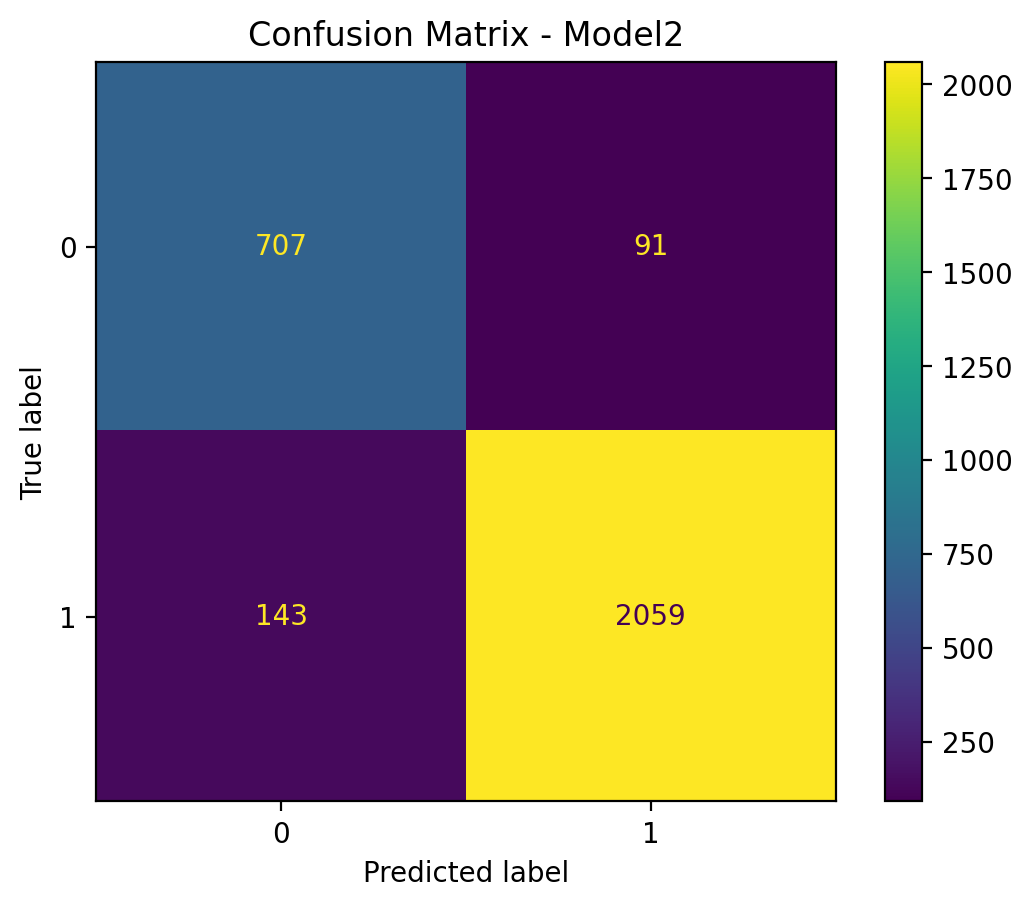

In [27]:
# =========================
# 3) Model2 평가
# =========================
print("=== Model2 (klue/roberta-base) ===")
print(classification_report(y_true2, y_pred2, target_names=["0","1"], digits=3))

cm2 = confusion_matrix(y_true2, y_pred2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["0","1"])
disp2.plot()
plt.title("Confusion Matrix - Model2")
plt.show()


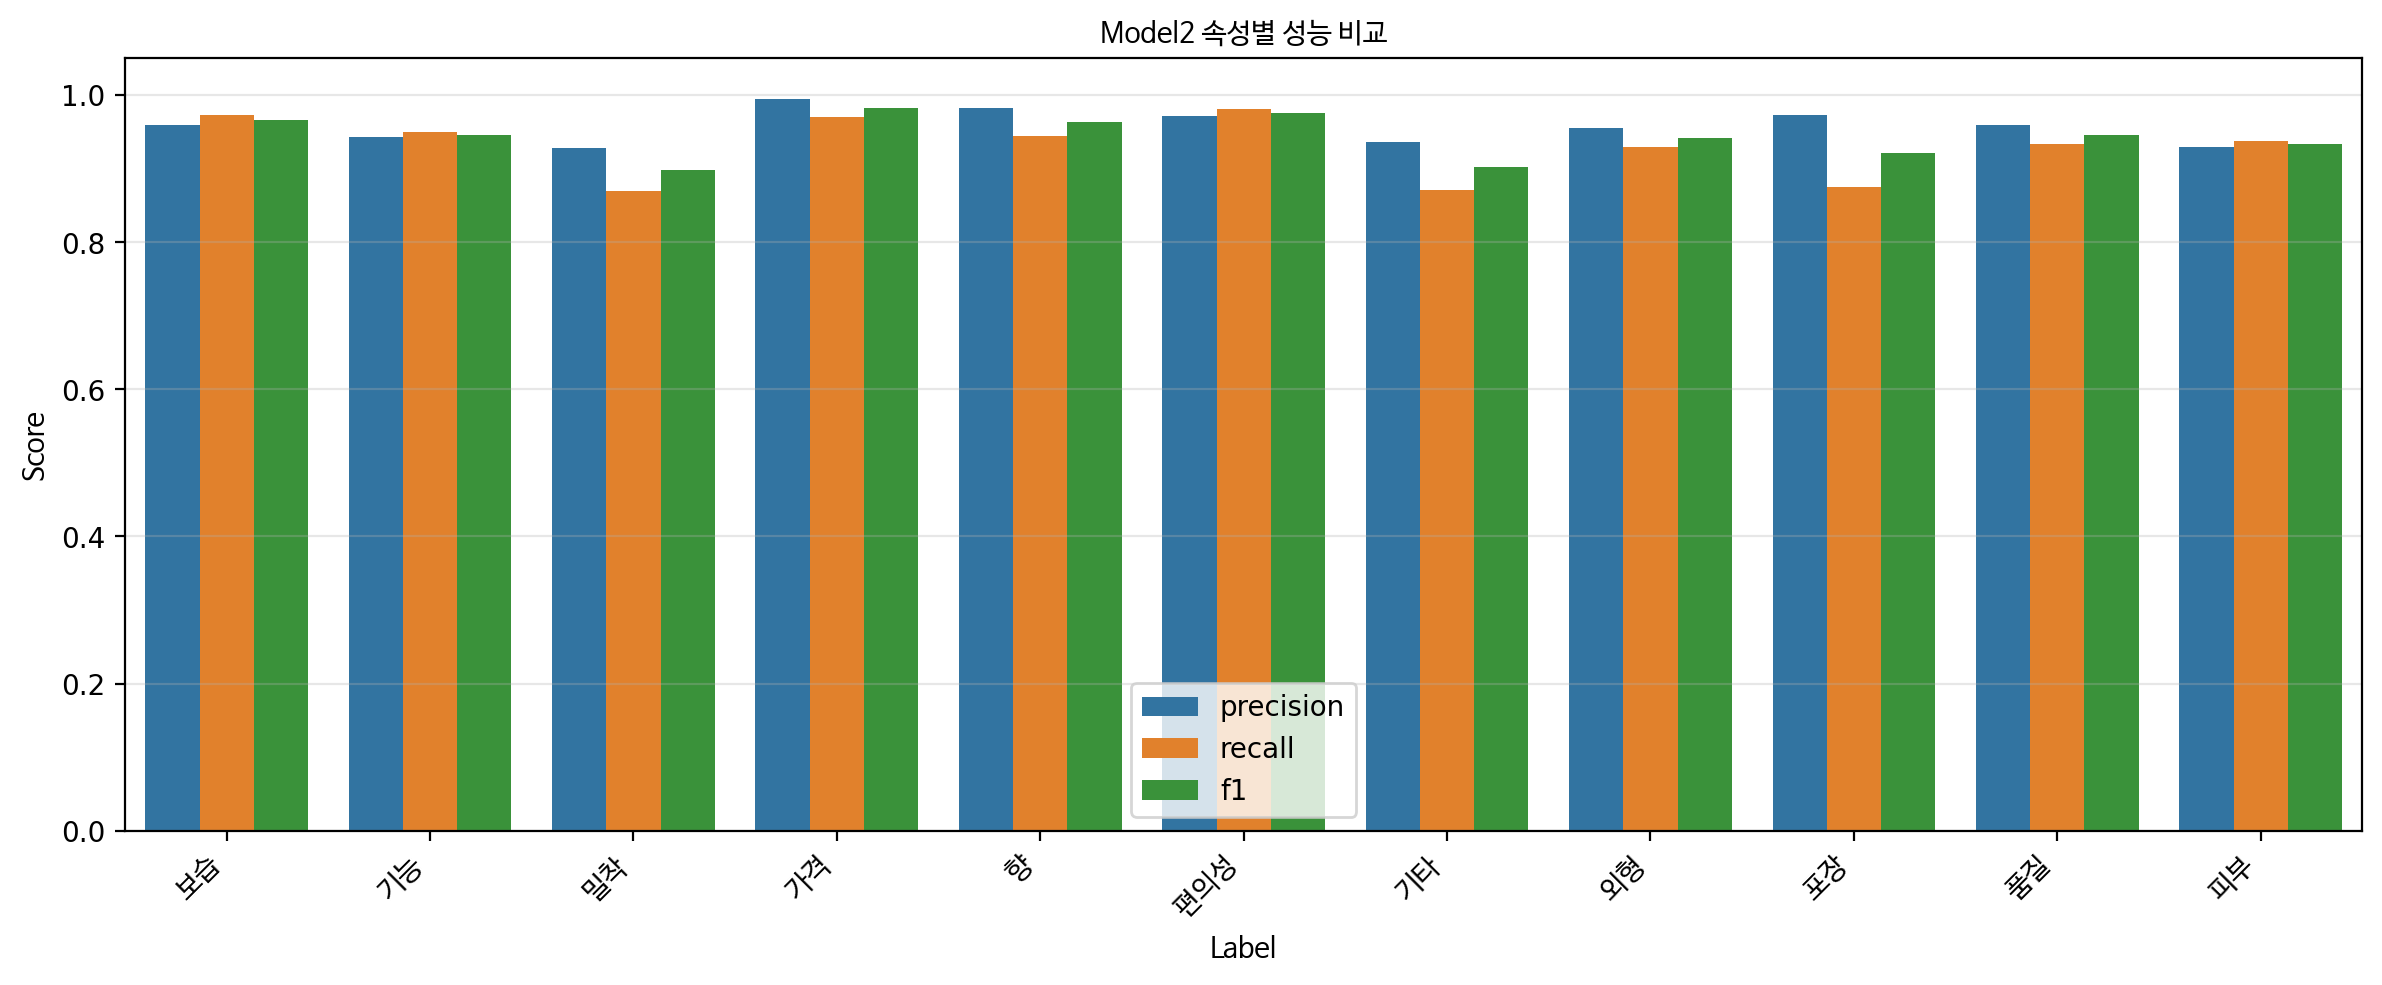

In [50]:
# =========================
# Model2 속성별 barplot
# =========================
df_melted_m2 = df_aspect_m2.melt(
    id_vars='label',
    value_vars=['precision', 'recall', 'f1'],
    var_name='metric',
    value_name='score'
)

plt.figure(figsize=(12,5))
sns.barplot(data=df_melted_m2, x='label', y='score', hue='metric')
plt.xticks(rotation=45, ha='right', fontproperties=fontprop)
plt.title("Model2 속성별 성능 비교", fontproperties=fontprop)
plt.ylabel("Score", fontproperties=fontprop)
plt.xlabel("Label", fontproperties=fontprop)
plt.ylim(0, 1.05)
plt.legend(prop=fontprop)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#robert가 더 좋은 모델이라 정확도가 높을것으로 예상했으나 0.3%정도 낮음, 강사님 말대로 모델이 좋다고 해서 항상 더 좋은 결과를 내는건 아니라는 판단(또는 내 코드가 엉망이거나)
#“[ASPECT] 속성 [SEP] 문장"의 방식은 정확도가 높은편이라 할 수 있겠다

## 3.방식② : 속성 : 문장

* 두가지 모델에 대해서 튜닝을 시도해봅시다.
    * model_name1 = "klue/bert-base"
    * model_name2 = "klue/roberta-base"

### (1) 데이터 준비
* 데이터셋 분할 및 텐서 데이터셋 변환
* 토크나이징 함수 안에서,
    * "ASPECT : 문장" 형태로 수정
    * 토크나이징

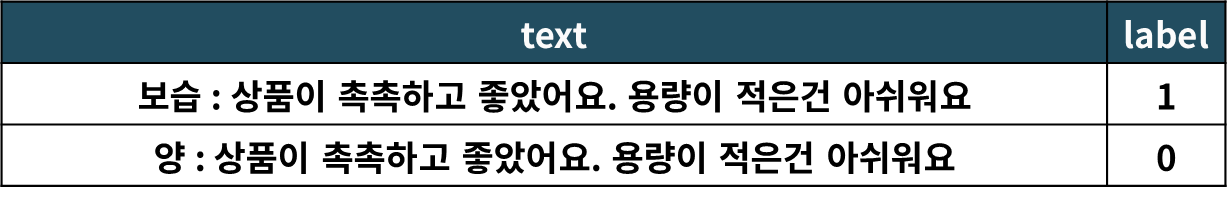

#### 1) 데이터셋 분할 및 텐서 데이터셋 변환

In [31]:
aspects = ['보습', '기능', '밀착', '가격', '향', '편의성', '기타', '외형', '포장', '품질', '피부']

In [32]:
# train, val 데이터 분할
train, val = train_test_split(df, test_size=0.3, random_state=100)

In [33]:
# df로 부터 텐서 데이터셋 만들기
train_ts = Dataset.from_pandas(train)
val_ts = Dataset.from_pandas(val)

In [34]:
train_ts[:3]

{'text': ['가격 착하고 향도 좋고 세팅력도 좋아서 자주 구매하게 되네요.',
  '정품이 맞는지 궁금합니다. 케이스가 견고하지 않는 것 같아요. 많이 매트합니다. 오전에 바르고 오후되니 화장이 다 뜨네요.',
  '날씨가 너무 추워져서 입술이 정말 건조한 것 같아요!! 건조할 때는 이 립밤을 바르시는 것을 추천 드릴게요!! 리뷰 바로 시작할게요~ㅎㅎ 보습력이 너무 좋아서 한 겨울에 이것만 발라도 입술이 절대 갈라지거나 건조하지 않는 꿀 아이템이라고 할 수 있어요!! 저는 개인적으로 이 립밤이 품질이 가장 좋은 것 같습니다! 사이즈도 들고 다니기 편하고 사용하기도 간편하게 제작이 되어 좋은 것 같아요! 향도 없어서 마음에 들고 무엇보다 뭉치지 않고 잘 발려서 정말 좋은 것 같습니다!! 겨울에 사용하기 좋은 립밤 찾으시면 저는 이 제품을 강력 추천 드리고 싶네요 ㅎㅎ'],
 'aspect': ['기능', '보습', '편의성'],
 'label': [1, 0, 1],
 '__index_level_0__': [12388, 51405, 37510]}

#### 2) 토크나이징
* "ASPECT : 문장" 형태로 수정
* 다중 레이블 분류 문제에서 label은 float 타입이어야 함

* 토크나이저 준비 : 두 모델에 대한 토크나이저 로딩

In [35]:
# 토크나이저 다운로드
model_name3 = "klue/bert-base"
model_name4 = "klue/roberta-base"
tokenizer3 = AutoTokenizer.from_pretrained(model_name3)
tokenizer4= AutoTokenizer.from_pretrained(model_name4)

* 토크나이징을 포함한 함수 생성 및 적용

In [42]:
# ===============================
# 0) 라벨 이름(반드시 실제 순서로 기입)
# ===============================
label_names = ['보습', '기능', '밀착', '가격', '향', '편의성', '기타', '외형', '포장', '품질', '피부']

def preprocess_aspect_pair_tok1(batch):
    # 첫 번째 시퀀스: "[ASPECT] {속성}", 두 번째 시퀀스: 문장
    left = [f"[ASPECT] : {a}" for a in batch["aspect"]]
    tok = tokenizer3(
        left,
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tok["labels"] = batch["label"]  # 0/1 (int)
    return tok

def preprocess_aspect_pair_tok2(batch):
    left = [f"[ASPECT] : {a}" for a in batch["aspect"]]
    tok = tokenizer4(
        left,
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tok["labels"] = batch["label"]
    return tok

# 전처리 적용
train_ts3 = train_ts.map(preprocess_aspect_pair_tok1, batched=True)
val_ts3 = val_ts.map(preprocess_aspect_pair_tok1, batched=True)
train_ts4 = train_ts.map(preprocess_aspect_pair_tok2, batched=True)
val_ts4 = val_ts.map(preprocess_aspect_pair_tok2, batched=True)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

### (2) Fine-Tuning

#### 1) 사전학습 모델 준비

In [43]:
# 모델1
num_labels = 2
model3 = AutoModelForSequenceClassification.from_pretrained(model_name3, num_labels=num_labels)


model3 = AutoModelForSequenceClassification.from_pretrained(model_name3, num_labels=2)
model3.resize_token_embeddings(len(tokenizer3))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32000, 768, padding_idx=0)

In [44]:
# 모델2
num_labels = 2
model4 = AutoModelForSequenceClassification.from_pretrained(model_name4, num_labels=num_labels)

model4 = AutoModelForSequenceClassification.from_pretrained(model_name4, num_labels=2)
model4.resize_token_embeddings(len(tokenizer4))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32000, 768, padding_idx=1)

#### 2) 학습 설정

* TrainingArguments 설정
    * 두 모델에 공통으로 하나만 설정해도 됨

In [45]:
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,               # 작은 학습률
    per_device_train_batch_size = 32,   # 학습 배치 사이즈
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,               # 에폭 수
    weight_decay = 0.02,                # weight decay
    load_best_model_at_end = True,      # earlystopping 사용하기 위해 필요
    logging_dir ='./logs',
    logging_steps = 10,
    report_to="tensorboard"
)

* Trainer 설정
    * 두 모델 각각 설정

In [46]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred        # logits: (B, 2), labels: (B,)
    preds = np.argmax(logits, axis=-1)
    labels = labels.reshape(-1)       # 혹시 (B,1)로 들어오면 평탄화
    return {
        "accuracy": accuracy_score(labels, preds),
        "weighted_f1": f1_score(labels, preds, average="weighted"),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }


In [47]:
# Trainer1 설정
trainer3 = Trainer(
    model=model3,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ts3,
    eval_dataset = val_ts3,
    tokenizer = tokenizer3,
    compute_metrics=compute_metrics,     # 추가 측정 지표
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)


# Trainer2 설정
trainer4 = Trainer(
    model=model4,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ts4,
    eval_dataset = val_ts4,
    tokenizer = tokenizer4,
    compute_metrics=compute_metrics,     # 추가 측정 지표
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)


/tmp/ipython-input-2954658813.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer3 = Trainer(
/tmp/ipython-input-2954658813.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer4 = Trainer(


#### 3) 학습

In [48]:
# 모델 학습
trainer3.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted F1,Macro F1
1,0.232500,0.221944,0.913333,0.909424,0.879597
2,0.148600,0.205317,0.926000,0.926881,0.907556
3,0.082400,0.245759,0.931667,0.931430,0.911901
4,0.055200,0.278586,0.934000,0.933894,0.915219
5,0.038400,0.304312,0.934333,0.934214,0.915613


TrainOutput(global_step=1095, training_loss=0.13379685430187885, metrics={'train_runtime': 908.2911, 'train_samples_per_second': 38.534, 'train_steps_per_second': 1.206, 'total_flos': 2302221734400000.0, 'train_loss': 0.13379685430187885, 'epoch': 5.0})

In [49]:
# 모델 학습
trainer4.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted F1,Macro F1
1,0.284100,0.257247,0.887667,0.879672,0.837314
2,0.166700,0.201991,0.925667,0.926435,0.906827
3,0.108600,0.235407,0.936000,0.935712,0.917319
4,0.067100,0.287353,0.936333,0.936422,0.918705
5,0.068400,0.305328,0.939667,0.939408,0.922088


TrainOutput(global_step=1095, training_loss=0.14659278091536537, metrics={'train_runtime': 881.6116, 'train_samples_per_second': 39.7, 'train_steps_per_second': 1.242, 'total_flos': 2302221734400000.0, 'train_loss': 0.14659278091536537, 'epoch': 5.0})

#### 4) 모델 검증평가

* 예측

In [51]:
# =========================
# 1) 예측 (Predict)
# =========================
raw_pred3 = trainer3.predict(val_ts3)
raw_pred4 = trainer4.predict(val_ts4)

# logits → 예측 라벨
logits3 = raw_pred3.predictions
logits4 = raw_pred4.predictions

y_true3 = raw_pred3.label_ids
y_true4 = raw_pred4.label_ids

y_pred3 = logits3.argmax(axis=1)
y_pred4 = logits4.argmax(axis=1)

In [61]:
# =========================
# 4) 속성별 성능 비교
# =========================
# val의 aspect 추출
val_aspects = list(val["aspect"].values)
aspect_list = aspects  # ['보습', '기능', '밀착', ..., '피부']

def per_aspect_scores(y_true, y_pred, aspect_seq, aspect_names):
    rows = []
    for a in aspect_names:
        idx = [i for i, x in enumerate(aspect_seq) if x == a]
        if len(idx) == 0:
            rows.append((a, np.nan, np.nan, np.nan, 0))
            continue
        yt = np.array(y_true)[idx]
        yp = np.array(y_pred)[idx]
        p, r, f1, sup = precision_recall_fscore_support(
            yt, yp, average="binary", zero_division=0
        )
        rows.append((a, p, r, f1, sup))
    return pd.DataFrame(rows, columns=["label","precision","recall","f1","support"])

df_aspect_m3 = per_aspect_scores(y_true3, y_pred3, val_aspects, aspect_list)
df_aspect_m4 = per_aspect_scores(y_true4, y_pred4, val_aspects, aspect_list)

print("\n[Model1] per-aspect metrics")
display(df_aspect_m3)

print("\n[Model2] per-aspect metrics")
display(df_aspect_m4)


[Model1] per-aspect metrics


,label,precision,recall,f1,support
0,보습,0.979239,0.962585,0.970840,None
1,기능,0.958333,0.929293,0.943590,None
2,밀착,0.931818,0.923423,0.927602,None
3,가격,0.994898,0.979899,0.987342,None
4,향,0.978261,0.957447,0.967742,None
5,편의성,0.970588,0.965854,0.968215,None
6,기타,0.959184,0.829412,0.889590,None
7,외형,0.966480,0.940217,0.953168,None
8,포장,0.923077,0.900000,0.911392,None
9,품질,0.964789,0.919463,0.941581,None



[Model2] per-aspect metrics


,label,precision,recall,f1,support
0,보습,0.969595,0.976190,0.972881,None
1,기능,0.934641,0.962963,0.948590,None
2,밀착,0.925581,0.896396,0.910755,None
3,가격,0.994898,0.979899,0.987342,None
4,향,0.986784,0.953191,0.969697,None
5,편의성,0.966346,0.980488,0.973366,None
6,기타,0.953020,0.835294,0.890282,None
7,외형,0.977273,0.934783,0.955556,None
8,포장,0.944954,0.858333,0.899563,None
9,품질,0.971223,0.906040,0.937500,None


* 평가

모델3평가

=== Model3 (klue/bert-base) ===
              precision    recall  f1-score   support

           0      0.834     0.901     0.866       798
           1      0.963     0.935     0.949      2202

    accuracy                          0.926      3000
   macro avg      0.899     0.918     0.908      3000
weighted avg      0.929     0.926     0.927      3000



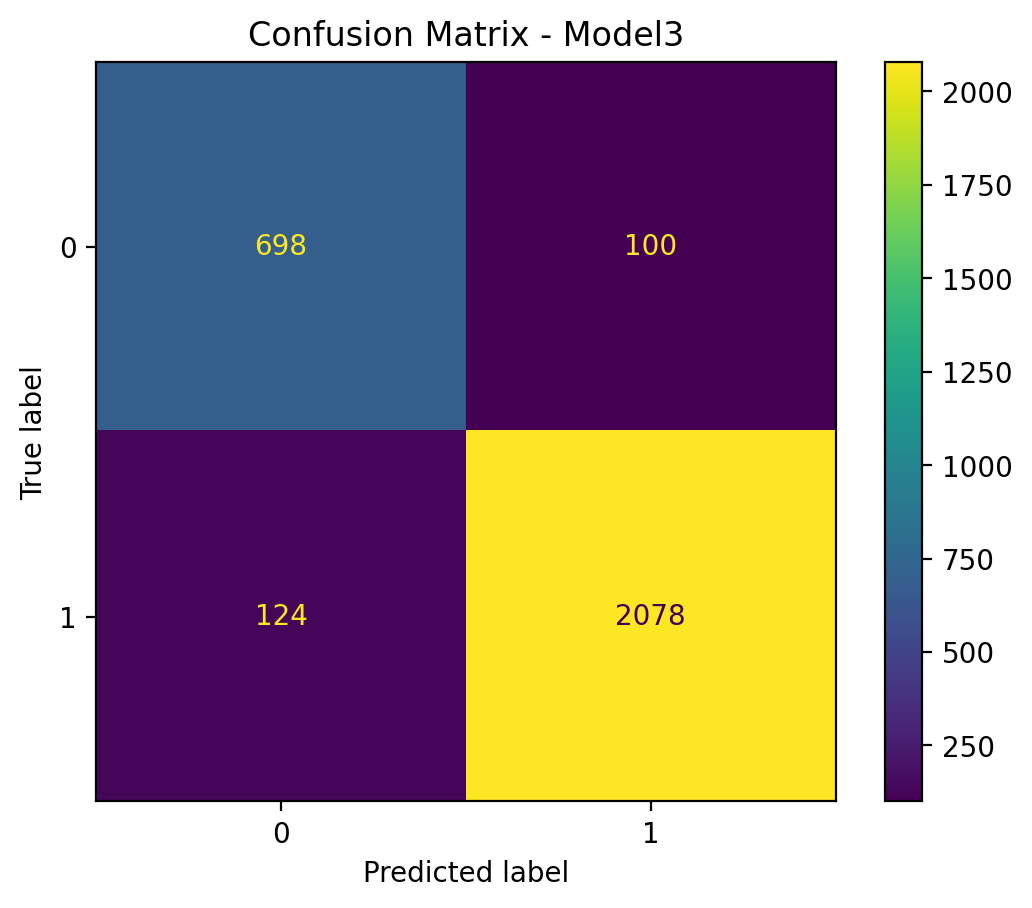

In [52]:
# =========================
# 2) Model3 평가
# =========================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("=== Model3 (klue/bert-base) ===")
print(classification_report(y_true3, y_pred3, target_names=["0","1"], digits=3))

cm3 = confusion_matrix(y_true3, y_pred3)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["0","1"])
disp3.plot()
plt.title("Confusion Matrix - Model3")
plt.show()


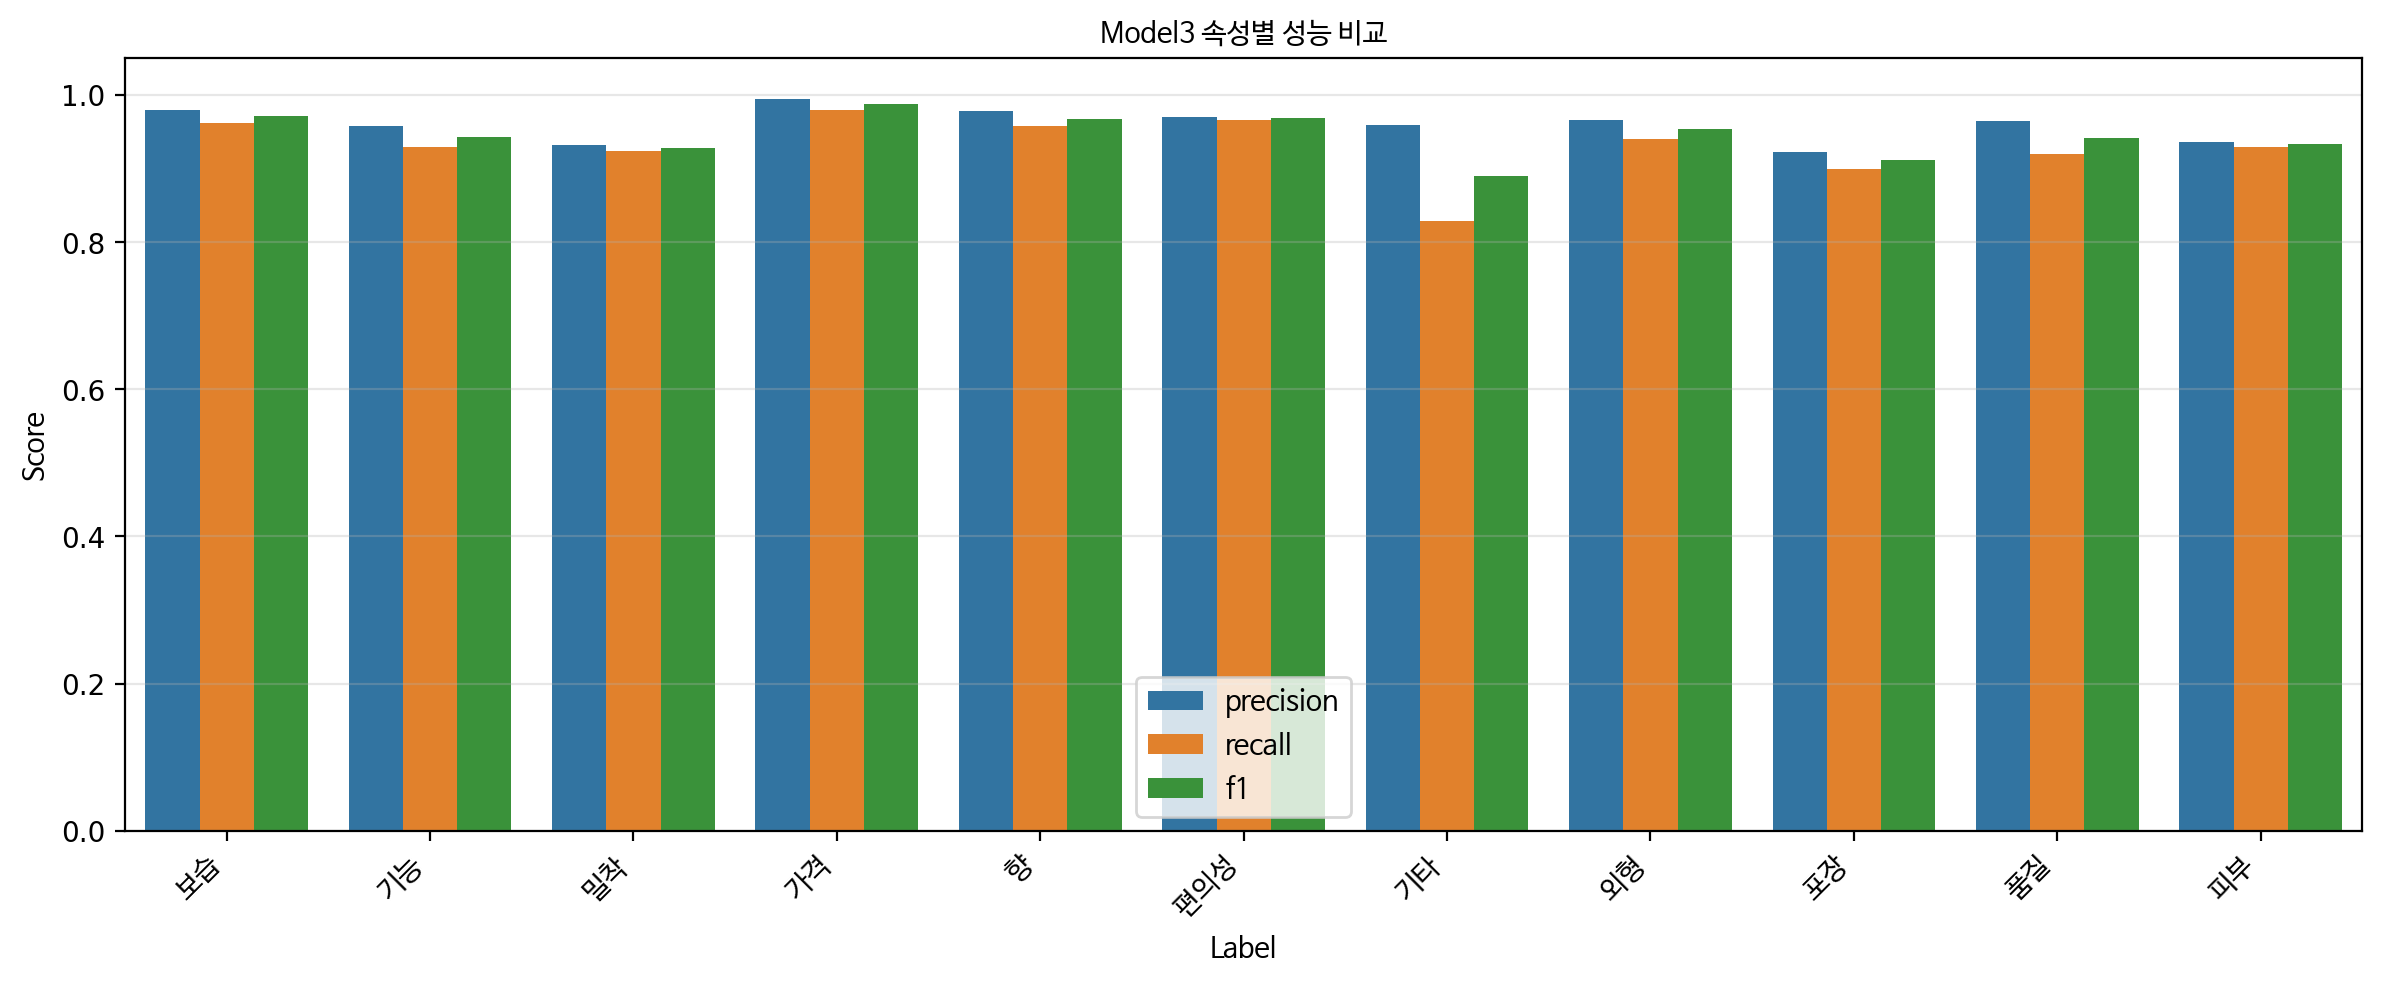

In [65]:
# barplot (Model3 예시)
df_melted3 = df_aspect_m3.melt(id_vars='label', value_vars=['precision', 'recall', 'f1'],
                              var_name='metric', value_name='score')

plt.figure(figsize=(12,5))
sns.barplot(data=df_melted3, x='label', y='score', hue='metric')
plt.xticks(rotation=45, ha='right', fontproperties=fontprop)
plt.title("Model3 속성별 성능 비교", fontproperties=fontprop)
plt.ylabel("Score", fontproperties=fontprop)
plt.xlabel("Label", fontproperties=fontprop)
plt.ylim(0, 1.05)
plt.legend(prop=fontprop)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


모델4 평가

=== Model4 (klue/roberta-base) ===
              precision    recall  f1-score   support

           0      0.837     0.895     0.865       798
           1      0.961     0.937     0.949      2202

    accuracy                          0.926      3000
   macro avg      0.899     0.916     0.907      3000
weighted avg      0.928     0.926     0.926      3000



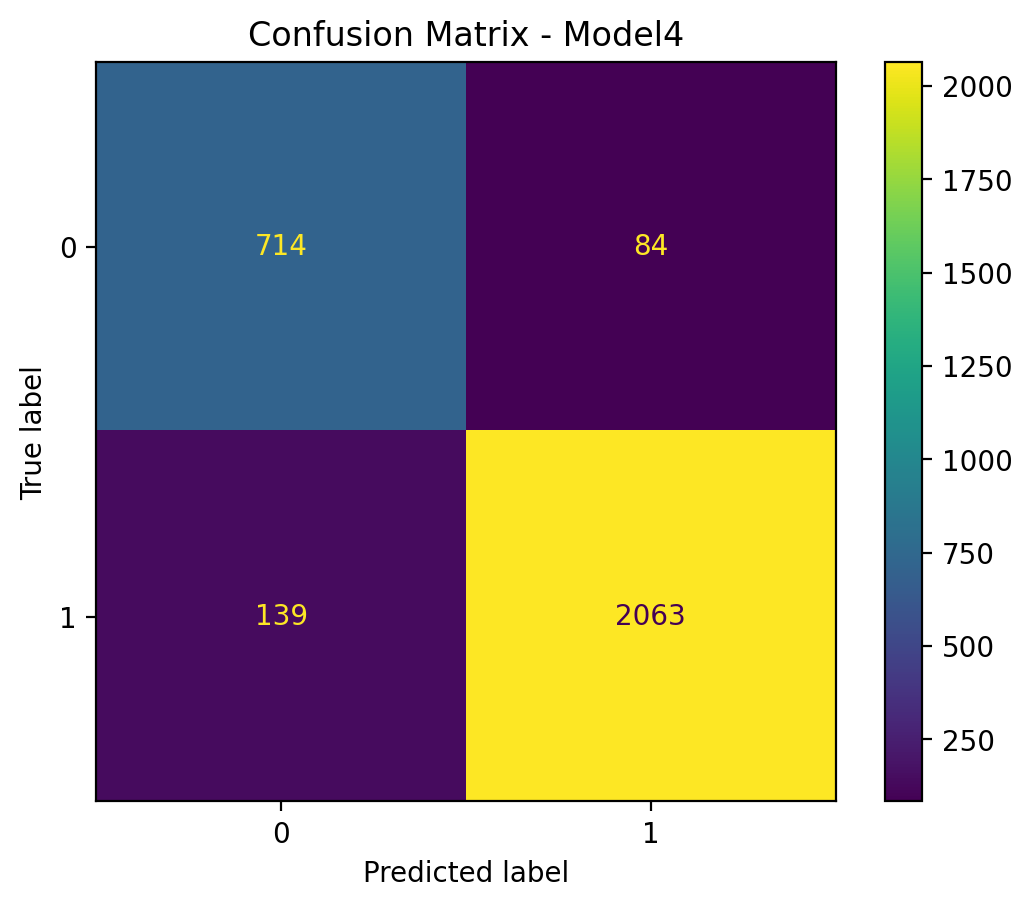

In [63]:
# =========================
# 3) Model4 평가
# =========================
print("=== Model4 (klue/roberta-base) ===")
print(classification_report(y_true4, y_pred4, target_names=["0","1"], digits=3))

cm4 = confusion_matrix(y_true4, y_pred4)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=["0","1"])
disp4.plot()
plt.title("Confusion Matrix - Model4")
plt.show()


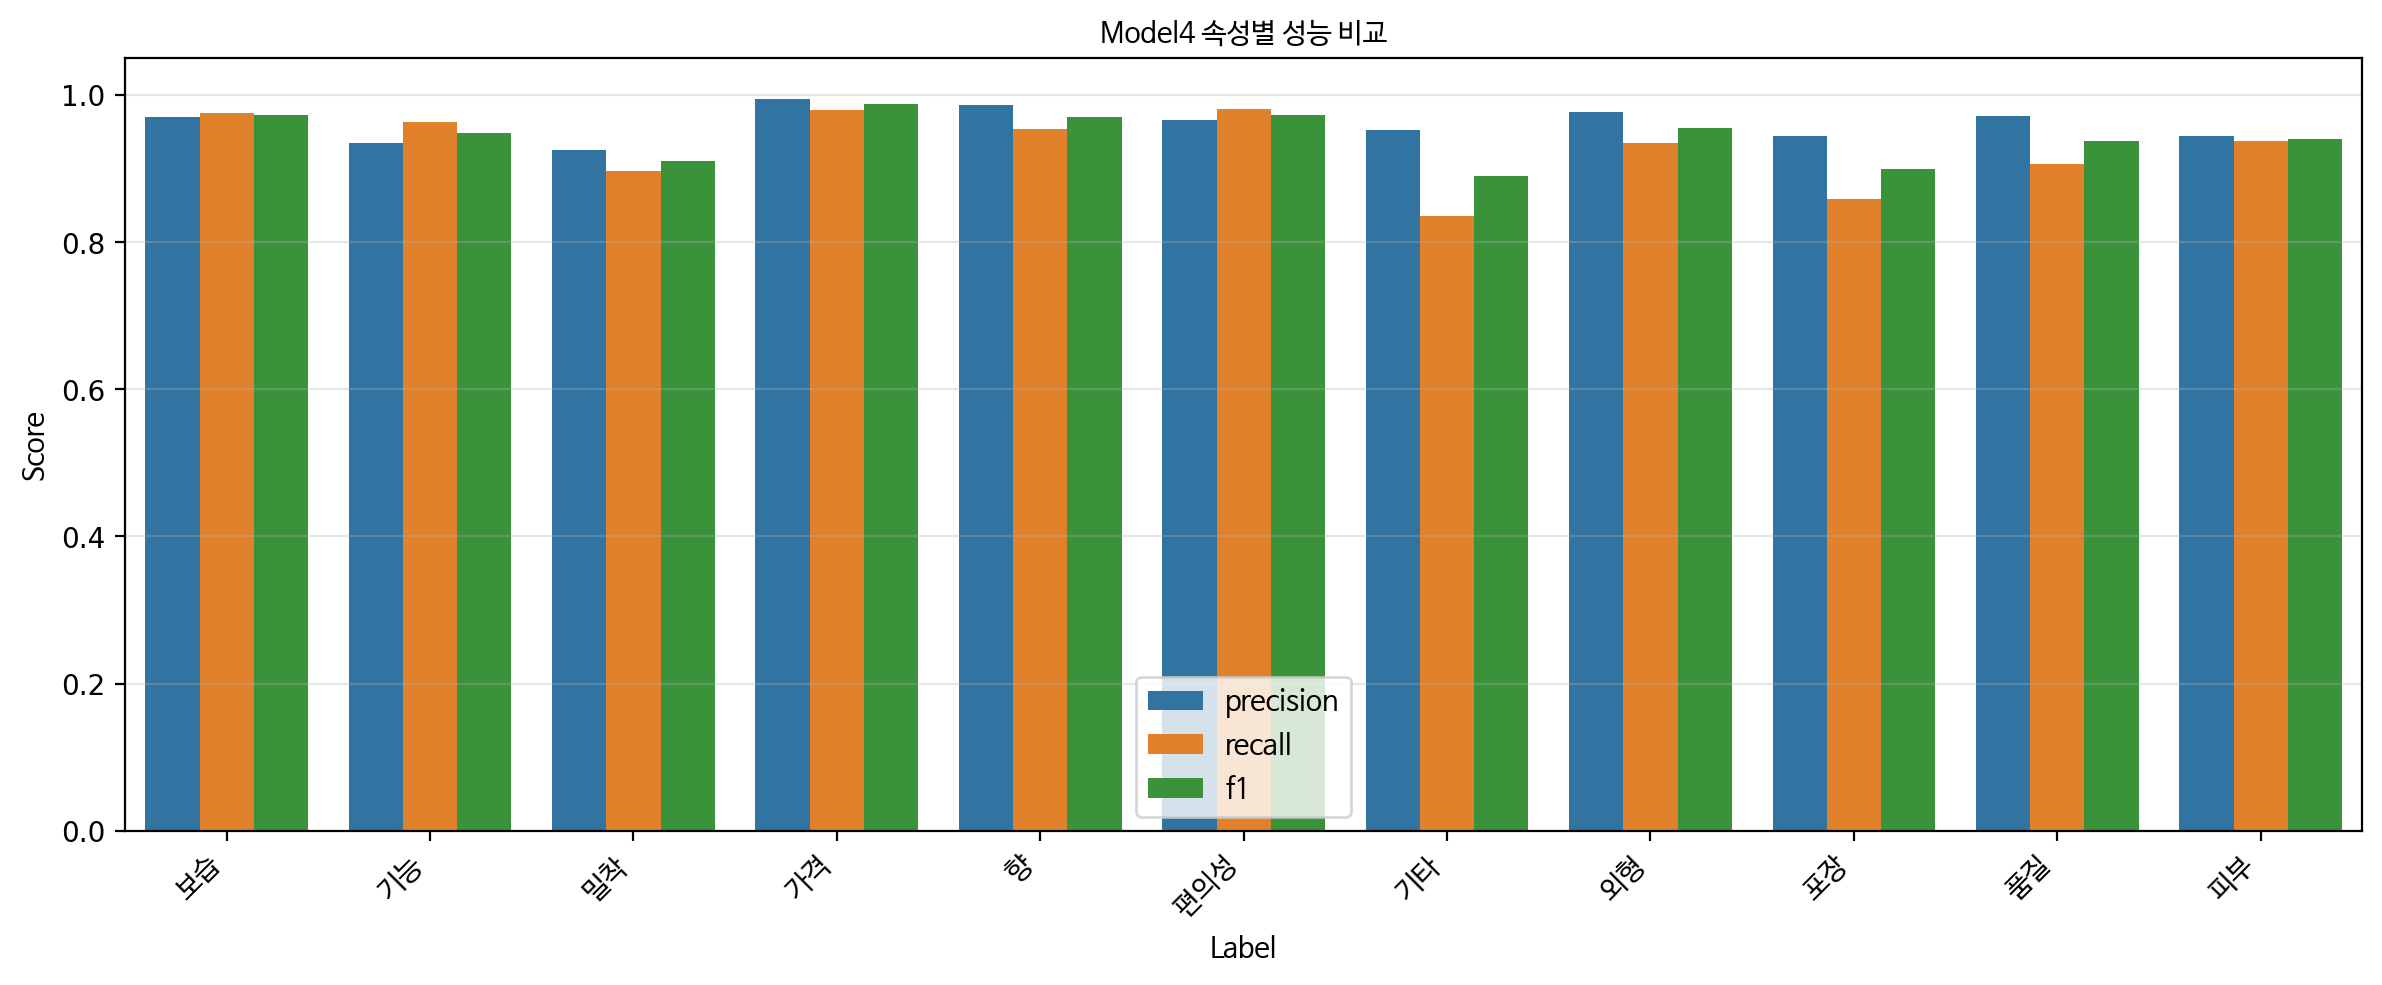

In [66]:
# =========================
# Model4 속성별 barplot
# =========================
df_melted_m4 = df_aspect_m4.melt(
    id_vars='label',
    value_vars=['precision', 'recall', 'f1'],
    var_name='metric',
    value_name='score'
)

plt.figure(figsize=(12,5))
sns.barplot(data=df_melted_m4, x='label', y='score', hue='metric')
plt.xticks(rotation=45, ha='right', fontproperties=fontprop)
plt.title("Model4 속성별 성능 비교", fontproperties=fontprop)
plt.ylabel("Score", fontproperties=fontprop)
plt.xlabel("Label", fontproperties=fontprop)
plt.ylim(0, 1.05)
plt.legend(prop=fontprop)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 모델	                                  구조	          Accuracy	특징
# Model1 (BERT + [ASPECT])	              스페셜토큰 사용	0.925	    안정적 baseline
# Model2 (Roberta + [ASPECT])	            스페셜토큰 사용	0.922	    BERT와 거의 동일
# Model3 (BERT 단순 문자열 “ASPECT :”)	  스페셜토큰 제거	0.926	    오히려 미세하게 ↑
# Model4 (Roberta 단순 문자열 “ASPECT :”)	스페셜토큰 제거	0.926


# 스페셜토큰 없이 단순 문자열 입력이 동일하거나 더 좋은 성능을 냈다.
# "[ASPECT] 속성 [SEP] 문장" 형태 보다 "ASPECT : 문장" 형태가 성능이 좋았다
